In [10]:
import pandas as pd
import os, sys
from collections import defaultdict
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [14]:
network = pd.read_csv('../data/network/vertex_attributes.csv')

network.shape

(1646, 16)

In [29]:
cols = [u'name', u'degree',  u'in', u'out', u'core', u'core-in', u'core-out', u'closeness', u'betweenness', u'eigen_centrality', u'pagerank', u'neighborhood', u'avg_neighborhood', u'authority', u'hub', u'clustering_coef']
network = network[cols]
network['name'] = network['name'].astype(str)
network['name'] = [col.split('@')[0] for col in network['name']]
network.head()

,name,degree,in,out,core,core-in,core-out,closeness,betweenness,eigen_centrality,pagerank,neighborhood,avg_neighborhood,authority,hub,clustering_coef
0,ortelius,9,0,9,5,0,4,0.050935,0.000000,0.000000,0.000174,10,340.285714,0.000000,0.027854,0.636905
1,jeff,895,417,478,23,12,10,0.053660,383864.171442,1.000000,0.133625,727,7.261634,1.000000,0.507906,0.092307
2,grmortimer,28,6,22,12,4,8,0.052364,13514.410073,0.008552,0.000698,24,303.924242,0.002657,0.054581,0.575758
3,akkana,1,0,1,1,0,1,0.046286,0.000000,0.000000,0.000174,2,1934.000000,0.000000,0.006788,NaN
4,marc.pfister,10,4,6,6,2,4,0.051793,1904.717481,0.001868,0.000300,9,619.600000,0.000635,0.018369,0.644444


### Global Measures

In [168]:
only_in = network['in'] > 0
no_out = network['out'] == 0

only_out = network['out'] > 0
no_in = network['in'] == 0

ask = network['in'] > 0
answer = network['out'] > 0


print "ONLY ASK:", network[(only_in & no_out)].shape[0]
print "ONLY ANSWER:", network[(only_out & no_in)].shape[0]
print "ASK AND ANSWER:", network[(ask & answer)].shape[0]

ONLY ASK: 464
ONLY ANSWER: 764
ASK AND ANSWER: 415


In [170]:
VERTICES: 1646 
EDGES: 4924
GLOBAL CC 0.0418348603048
AVG PATH LENGTH 2.74013916003
CLIQUES 138340
CLIQUE NO 14
DIAMETER 22.0
RECIPROCITY 0.245735174655
LARGEST CLUSTER SIZE 378 Vertices, 2708 Edges

ONLY ASKED QUETIONS: 464
ONLY ANSWER ANSWERED: 764
ASKED AND ANSWER: 415

### Local Measures

In [40]:
cols = [u'name', u'degree',  u'in', u'out', u'core', u'core-in', u'core-out', u'closeness', u'betweenness', u'eigen_centrality', u'pagerank', u'neighborhood', u'avg_neighborhood', u'authority', u'hub', u'clustering_coef']
network = network[cols]
network.apply(pd.to_numeric, errors='ignore')
print network.describe().round(4).loc[['mean', 'std', 'min', 'max']].T

                       mean         std     min          max
degree               5.9830     30.6500  0.0000     895.0000
in                   2.9915     15.3362  0.0000     417.0000
out                  2.9915     15.7134  0.0000     478.0000
core                 3.1422      3.9024  0.0000      23.0000
core-in              1.3621      2.1560  0.0000      12.0000
core-out             1.4216      1.9871  0.0000      10.0000
closeness            0.0492      0.0054  0.0006       0.0537
betweenness       1349.3092  12844.0691  0.0000  383864.1714
eigen_centrality     0.0050      0.0368  0.0000       1.0000
pagerank             0.0006      0.0043  0.0002       0.1336
neighborhood         6.2479     24.9207  1.0000     727.0000
avg_neighborhood  1431.9329   1726.0096  1.0000    5802.0000
authority            0.0029      0.0291  0.0000       1.0000
hub                  0.0070      0.0421  0.0000       1.0000
clustering_coef      0.9397      0.6718  0.0000       2.0000


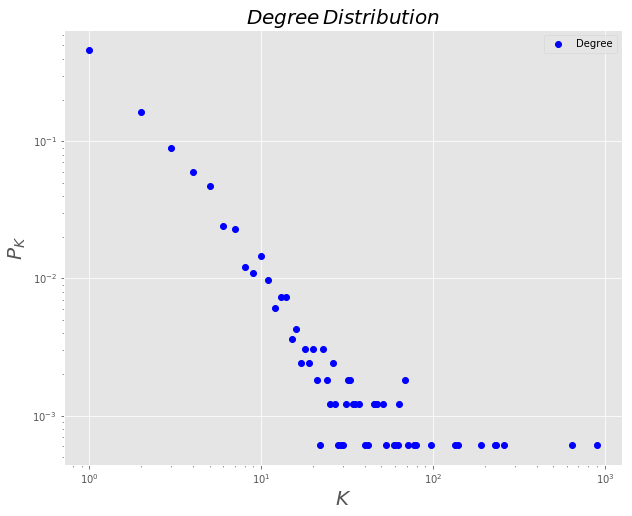

In [63]:
plotDegreeDistribution(network['degree'])

In [30]:
network.sort_values(by=['degree','in', 'out'], ascending=[0,0,0]).head(20)

,name,degree,in,out,core,core-in,core-out,closeness,betweenness,eigen_centrality,pagerank,neighborhood,avg_neighborhood,authority,hub,clustering_coef
1,jeff,895,417,478,23,12,10,0.053660,383864.171442,1.000000,0.133625,727,7.261634,1.000000,0.507906,0.092307
16,liz,641,341,300,23,12,10,0.053378,289086.256950,0.817155,0.092741,519,11.878386,0.436667,1.000000,0.164351
39,stevie,257,153,104,23,12,10,0.052174,93564.152253,0.296243,0.032701,208,37.977670,0.201496,0.201559,0.224124
7,shannon,233,151,82,23,12,10,0.052445,90494.619408,0.439042,0.036744,190,32.694071,0.298163,0.273464,0.334016
29,mathew,229,92,137,23,12,10,0.052635,94099.819578,0.173311,0.014276,197,54.010458,0.105548,0.315205,0.325060
9,cfastie,190,63,127,23,12,10,0.052437,72814.142002,0.168511,0.012299,161,39.322515,0.089426,0.623927,0.365530
88,donblair,140,68,72,23,12,10,0.051970,26419.185693,0.244601,0.015889,114,40.321053,0.146916,0.571972,0.480833
21,eustatic,134,64,70,23,12,10,0.052197,33435.842990,0.089215,0.009355,104,65.308219,0.050801,0.275078,0.469899
333,btbonval,97,46,51,23,12,10,0.051725,15249.125639,0.119217,0.007048,78,58.025641,0.056408,0.536428,0.622513
8,pat,79,43,36,23,12,10,0.051952,21503.697606,0.064505,0.006035,67,104.659824,0.037311,0.183235,0.580269


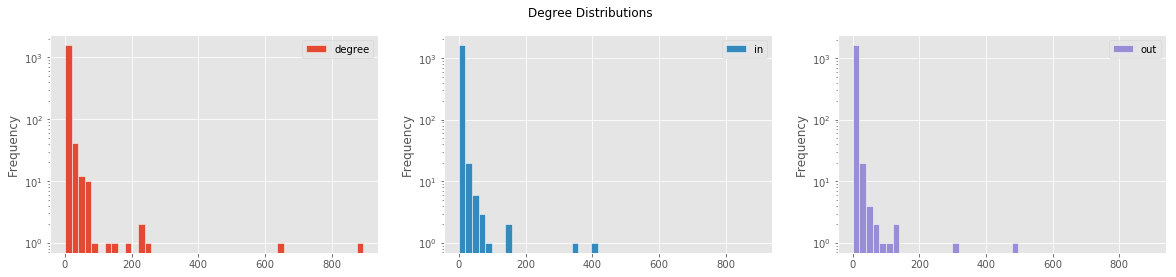

In [100]:
title = 'Degree Distributions'
degrees = network[['degree', 'in', 'out']]
degrees.plot(kind='hist', subplots=True, layout=(1,3), title=title, log=True, figsize=(20, 4), bins=45, edgecolor='w')
# plt.plot()
plt.show()

### Top Question People

In [32]:
labels =[u'core', u'core-in', u'core-out', u'closeness', u'betweenness', u'eigen_centrality', u'pagerank', u'neighborhood', u'authority', u'hub', u'clustering_coef']
questioners = network.drop(labels, axis=1)
questioners.describe()

,degree,in,out,avg_neighborhood
count,1646.000000,1646.000000,1646.000000,1643.000000
mean,5.982989,2.991495,2.991495,1431.932876
std,30.649975,15.336190,15.713388,1726.009638
min,0.000000,0.000000,0.000000,1.000000
25%,1.000000,0.000000,0.000000,152.000000
50%,2.000000,1.000000,1.000000,736.250000
75%,4.000000,2.000000,2.000000,1934.000000
max,895.000000,417.000000,478.000000,5802.000000


In [33]:
labels =[u'core', u'core-in', u'core-out', u'closeness', u'betweenness', u'eigen_centrality', u'pagerank', u'neighborhood', u'authority', u'hub', u'clustering_coef']
questioners = network.drop(labels, axis=1)
indegree = questioners['in'] < 3
outdegree = questioners['out'] < 3
avg_neighborhood = questioners['avg_neighborhood'] > 1934
query = (indegree & outdegree & avg_neighborhood)

top_questioners = questioners[query].sort_values(by=['avg_neighborhood', 'in', 'out', ], ascending=[0, 0, 1])
top_questioners.shape[0]

371

In [37]:
top_questioners.head(10)

,name,degree,in,out,avg_neighborhood
27,jbernson50,1,1,0,5802.0
166,curiosity.catbait,1,1,0,5802.0
178,christolles,1,1,0,5802.0
247,natalia.santos,1,1,0,5802.0
248,svsimms,1,1,0,5802.0
270,shervinafshar,1,1,0,5802.0
443,domlesky,1,1,0,5802.0
449,ethan.m.mcmahon,1,1,0,5802.0
477,rahima,1,1,0,5802.0
486,johnstonel,1,1,0,5802.0


### Top Answer People

In [34]:
labels = [u'in', u'core', u'core-in', u'core-out', u'closeness', u'betweenness', u'eigen_centrality', u'pagerank', u'neighborhood', u'authority', u'hub']
answerers = network.drop(labels, axis=1)
answerers['percent-out'] = answerers['out'].div(answerers['degree'])
answerers = answerers.drop(['out', 'degree'], axis=1).dropna()

answerers.describe()

,avg_neighborhood,clustering_coef,percent-out
count,880.000000,880.000000,880.000000
mean,1039.824533,0.939720,0.467393
std,1002.864063,0.671753,0.385581
min,1.000000,0.000000,0.000000
25%,327.094394,0.427910,0.000000
50%,706.808824,0.829496,0.500000
75%,1467.125000,1.482143,0.888889
max,5802.000000,2.000000,1.000000


In [35]:
avg_neighborhood = answerers['avg_neighborhood'] < 328
clustering_coef = answerers['clustering_coef'] < 0.42
percent_out = answerers['percent-out'] > .88

query = (percent_out & clustering_coef & avg_neighborhood)
top_answerers = answerers[query].sort_values(by=['avg_neighborhood', 'clustering_coef', 'percent-out', ], ascending=[0, 0, 1])

top_answerers.shape[0]

37

In [36]:
answerers.head(10)

,name,avg_neighborhood,clustering_coef,percent-out
0,ortelius,340.285714,0.636905,1.000000
1,jeff,7.261634,0.092307,0.534078
2,grmortimer,303.924242,0.575758,0.785714
4,marc.pfister,619.600000,0.644444,0.600000
5,labrune,1179.200000,1.266667,0.500000
6,dana.bauer,592.566667,0.907692,0.285714
7,shannon,32.694071,0.334016,0.351931
8,pat,104.659824,0.580269,0.455696
9,cfastie,39.322515,0.365530,0.668421
10,grasshopperrocket,143.888889,2.000000,1.000000


### Top Discussion Starters

In [38]:
labels = [u'in', u'core', u'core-in', u'core-out', u'closeness', u'betweenness', u'eigen_centrality', u'pagerank', u'neighborhood', u'authority', u'hub']
starters = network.drop(labels, axis=1)
starters['percent-out'] = starters['out'].div(starters['degree'])
starters = starters.drop(['out', 'degree'], axis=1).dropna()

starters.describe()

,avg_neighborhood,clustering_coef,percent-out
count,880.000000,880.000000,880.000000
mean,1039.824533,0.939720,0.467393
std,1002.864063,0.671753,0.385581
min,1.000000,0.000000,0.000000
25%,327.094394,0.427910,0.000000
50%,706.808824,0.829496,0.500000
75%,1467.125000,1.482143,0.888889
max,5802.000000,2.000000,1.000000


In [39]:
avg_neighborhood = answerers['avg_neighborhood'] > 1467
clustering_coef = answerers['clustering_coef'] > 1.48
percent_out = answerers['percent-out']  == 0

query = (percent_out & clustering_coef & avg_neighborhood)
top_starters = starters[query].sort_values(by=['percent-out',  'clustering_coef','avg_neighborhood'], ascending=[1, 0, 0])

top_starters.shape[0]

51

In [40]:
top_starters.head(10)

,name,avg_neighborhood,clustering_coef,percent-out
516,ivan.ferrero1975,4710.0,2.0,0.0
1103,lionheadrex,4710.0,2.0,0.0
1389,zenskunkworx,4710.0,2.0,0.0
1524,michael.john.kirk,4710.0,2.0,0.0
558,bhaveshtk,3416.0,2.0,0.0
1018,mariko.kosaka,3416.0,2.0,0.0
769,keidruck,3394.0,2.0,0.0
804,fjcaceres,3394.0,2.0,0.0
787,kaplana,3283.5,2.0,0.0
1161,rodrigowalsh,3283.5,2.0,0.0


In [45]:
posters = pd.read_csv('../data/network/posting_statistics.csv')
posters['user'] = posters['user'].astype(str)
posters['user'] = [col.split('@')[0] for col in posters['user']]
top_posters = posters.sort_values(by=['posts'], ascending=[0])
top_posters.head(10)

,user,posts,op,replies
0,jeff,6468,2496,3972
1,liz,4283,1940,2343
2,stevie,3072,2361,711
3,shannon,2465,1916,549
4,cfastie,993,153,840
5,donblair,828,130,698
6,mathew,717,197,520
7,eustatic,640,209,431
8,btbonval,578,74,504
9,pat,472,242,230


### Top Experts

In [46]:
labels = [u'degree',  u'in', u'out', u'core', u'core-in', u'core-out', u'neighborhood', u'avg_neighborhood']

centralities = network.drop(labels, axis=1)
top_experts = centralities.sort_values(by=['pagerank'], ascending=[0])
top_experts.loc[:, ['name', 'pagerank', 'hub', 'eigen_centrality']].head(15)

,name,pagerank,hub,eigen_centrality
1,jeff,0.133625,5.079059e-01,1.000000
16,liz,0.092741,1.000000e+00,0.817155
7,shannon,0.036744,2.734644e-01,0.439042
39,stevie,0.032701,2.015592e-01,0.296243
88,donblair,0.015889,5.719718e-01,0.244601
29,mathew,0.014276,3.152047e-01,0.173311
9,cfastie,0.012299,6.239272e-01,0.168511
21,eustatic,0.009355,2.750777e-01,0.089215
22,stewart,0.008511,8.145990e-02,0.120003
821,shannon....,0.008165,8.426816e-07,0.000000


### Top hubs

In [47]:
top_hubs = centralities.sort_values(by=['hub'], ascending=[0])
top_hubs.loc[:, ['name', 'pagerank', 'hub', 'eigen_centrality']].head(15)

,name,pagerank,hub,eigen_centrality
16,liz,0.092741,1.000000,0.817155
9,cfastie,0.012299,0.623927,0.168511
88,donblair,0.015889,0.571972,0.244601
333,btbonval,0.007048,0.536428,0.119217
1,jeff,0.133625,0.507906,1.000000
29,mathew,0.014276,0.315205,0.173311
21,eustatic,0.009355,0.275078,0.089215
7,shannon,0.036744,0.273464,0.439042
26,adamdgriffith,0.001730,0.243654,0.025396
35,fiestin,0.007428,0.238281,0.143176


### Importance relative to other important people

In [48]:
top_import = centralities.sort_values(by=['eigen_centrality'], ascending=[0])
top_import.loc[:, ['name', 'pagerank', 'hub', 'eigen_centrality']].head(15)

,name,pagerank,hub,eigen_centrality
1,jeff,0.133625,0.507906,1.000000
16,liz,0.092741,1.000000,0.817155
7,shannon,0.036744,0.273464,0.439042
39,stevie,0.032701,0.201559,0.296243
88,donblair,0.015889,0.571972,0.244601
29,mathew,0.014276,0.315205,0.173311
344,sreyanth,0.005434,0.148673,0.168710
9,cfastie,0.012299,0.623927,0.168511
35,fiestin,0.007428,0.238281,0.143176
22,stewart,0.008511,0.081460,0.120003


### Top bridges

In [49]:
top_bridges = centralities.sort_values(by=['betweenness'], ascending=[0])
top_bridges.loc[:, ['name', 'betweenness']].head(15)

,name,betweenness
1,jeff,383864.171442
16,liz,289086.256950
29,mathew,94099.819578
39,stevie,93564.152253
7,shannon,90494.619408
9,cfastie,72814.142002
21,eustatic,33435.842990
194,steviepubliclab,28294.715641
88,donblair,26419.185693
33,dan.beavers,23392.880606


In [7]:
loc_idx = [ u'plots-barnraising', u'Publiclab-mountainwest', u'laboratoriopublico', u'plots-amsterdam', u'plots-baltimore-dc', u'plots-boston', 
             u'plots-gulfcoast', u'plots-norcal', u'plots-nyc', u'plots-philadelphia',  u'plots-providence', u'plots-skane', 
             u'plots-southeast', u'public-lab-chicago', u'public-lab-northwest', u'public-lab-vancouver', u'publiclab-jerusalem', 
             u'publiclab-la', u'publiclab-midwest', u'publiclab-northeast', u'publiclab-portugues', 'plots-butte']

tools_idx = [u'grassrootsmapping', u'plots-airquality', u'plots-alpha', u'plots-dev', u'plots-education', 
              u'plots-gsoc', u'plots-infrared', u'plots-kickstarter', u'plots-organizers', u'plots-potentiostat',
              u'plots-spectrometry', u'plots-waterquality',  u'public-lab-writing-group', u'publiclaboratory']

In [8]:
tool_forums = pd.read_csv('../data/network/top_posters_tools_stats.csv')
tool_forums.index = tools_idx
tool_forums

,btbonval,cfastie,donblair,eustatic,jeff,liz,shannon,stevie
grassrootsmapping,0,77,14,36,754,270,209,113
plots-airquality,0,3,0,0,35,45,5,11
plots-alpha,20,31,2,0,94,17,7,0
plots-dev,112,23,21,4,807,191,41,112
plots-education,0,1,3,3,36,68,72,94
plots-gsoc,51,17,18,1,415,24,0,5
plots-infrared,5,413,185,3,454,139,98,105
plots-kickstarter,0,0,0,0,0,0,0,0
plots-organizers,242,148,208,170,943,846,563,396
plots-potentiostat,0,0,0,0,0,41,43,94


In [9]:
loc_forums = pd.read_csv('../data/network/top_posters_location_stats.csv')
loc_forums.index = loc_idx
loc_forums

,btbonval,cfastie,donblair,eustatic,jeff,liz,shannon,stevie
plots-barnraising,17,21,26,48,86,175,74,90
Publiclab-mountainwest,0,0,0,0,0,1,0,1
laboratoriopublico,0,0,0,0,42,4,2,1
plots-amsterdam,1,1,0,1,24,40,70,91
plots-baltimore-dc,1,0,0,1,30,76,66,94
plots-boston,35,17,55,3,362,147,80,85
plots-gulfcoast,1,5,3,252,59,95,178,329
plots-norcal,1,0,0,1,37,54,74,97
plots-nyc,5,10,12,7,83,664,83,95
plots-philadelphia,1,4,1,1,25,93,69,94


In [4]:
#http://www.pythonexample.com/code/plot-degree-distribution-igraph-python/

def plotDegreeDistribution(degrees):
    degs = defaultdict(int)
    for i in degrees: 
        degs[i]+=1
    items = sorted ( degs.items () )
    x, y = np.array(items).T
    y = [float(i) / sum(y) for i in y]
    plt.figure(figsize=(10,8))
    plt.plot(x, y, 'bo')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(['Degree'])
    plt.xlabel('$K$', fontsize = 20)
    plt.ylabel('$P_K$', fontsize = 20)
    plt.title('$Degree\,Distribution$', fontsize = 20)
    plt.show()